In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/molecular-machine-learning/sample_submission.csv
/kaggle/input/molecular-machine-learning/train.csv
/kaggle/input/molecular-machine-learning/test.csv


# Molecular Data Machine Learning 
### Author : Dur e Yashfeen

## Step 1: Importing ncessary libraries 📦

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')


## Step 2: 📂  Load the data

In [3]:
# load the data 
df_tr = pd.read_csv("/kaggle/input/molecular-machine-learning/train.csv")
df_ts = pd.read_csv("/kaggle/input/molecular-machine-learning/test.csv")
submission_file = pd.read_csv("/kaggle/input/molecular-machine-learning/sample_submission.csv")

## Step 3: Basic Overview 🔍 

In [4]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Columns: 146 entries, Batch_ID to SDOS5.4
dtypes: float64(138), int64(6), object(2)
memory usage: 48.0+ KB


In [5]:
df_tr.describe()

,T80,Mass,HAcceptors,HDonors,LogP,Asphericity,Rg,TPSA,RingCount,NumRotatableBonds,...,SDOS4.5,SDOS4.6,SDOS4.7,SDOS4.8,SDOS4.9,SDOS5.0,SDOS5.1,SDOS5.2,SDOS5.3,SDOS5.4
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,...,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,22.710476,601.389929,5.500000,0.309524,10.854289,0.532680,6.355368,36.990952,5.714286,11.690476,...,0.874759,0.763264,0.668653,0.595143,0.560035,0.571105,0.624577,0.706185,0.786314,0.833714
std,26.896407,176.251665,2.244234,0.604378,3.504098,0.217963,1.264587,30.888275,1.743080,6.884015,...,0.993377,0.872205,0.720167,0.580504,0.541022,0.568734,0.597270,0.665208,0.769713,0.814881
min,1.500000,238.315000,2.000000,0.000000,3.872100,0.169945,3.629240,0.000000,2.000000,2.000000,...,0.012396,0.014004,0.024370,0.037166,0.039435,0.051700,0.049996,0.034589,0.030793,0.057340
25%,5.085000,483.691250,4.000000,0.000000,8.369075,0.345224,5.593117,17.980000,5.000000,4.000000,...,0.158100,0.107728,0.150733,0.195820,0.239064,0.283035,0.220079,0.235281,0.250824,0.236877
50%,10.485000,570.826000,5.000000,0.000000,10.801500,0.541883,6.289388,36.225000,5.000000,14.000000,...,0.449055,0.363273,0.333565,0.330316,0.410859,0.371651,0.427824,0.475996,0.488769,0.473099
75%,30.182500,751.587000,6.750000,0.000000,13.054580,0.714117,6.951290,50.075000,7.000000,17.000000,...,1.232151,1.191322,1.086311,0.913003,0.712412,0.718112,0.964893,1.124234,1.386218,1.418428
max,103.860000,1005.426000,12.000000,2.000000,17.767000,0.913014,10.519416,132.990000,9.000000,23.000000,...,3.765836,2.986408,2.431030,2.394081,2.738119,3.060757,3.103451,2.908210,2.818927,3.188643


## Step 4: Imputing missing Values & Outliers

In [6]:
df_tr.columns

Index(['Batch_ID', 'T80', 'Smiles', 'Mass', 'HAcceptors', 'HDonors', 'LogP',
       'Asphericity', 'Rg', 'TPSA',
       ...
       'SDOS4.5', 'SDOS4.6', 'SDOS4.7', 'SDOS4.8', 'SDOS4.9', 'SDOS5.0',
       'SDOS5.1', 'SDOS5.2', 'SDOS5.3', 'SDOS5.4'],
      dtype='object', length=146)

In [7]:
df_tr.isnull().sum()

Batch_ID      0
T80           0
Smiles        0
Mass          0
HAcceptors    0
             ..
SDOS5.0       0
SDOS5.1       0
SDOS5.2       0
SDOS5.3       0
SDOS5.4       0
Length: 146, dtype: int64

In [8]:
# Outlier imputation function
def impute_outliers(df):
    df_out = df.copy()
    numeric_cols = df_out.select_dtypes(include=[np.number]).columns.tolist()
    if "T80" in numeric_cols:
        numeric_cols.remove("T80")  # exclude target from imputation
    for col in numeric_cols:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = (df_out[col] < lower) | (df_out[col] > upper)
        median = df_out[col].median()
        df_out.loc[outliers, col] = median
    return df_out

# Clean both train and test
df_tr = impute_outliers(df_tr)
df_ts = impute_outliers(df_ts)

## Step 5: Visualization

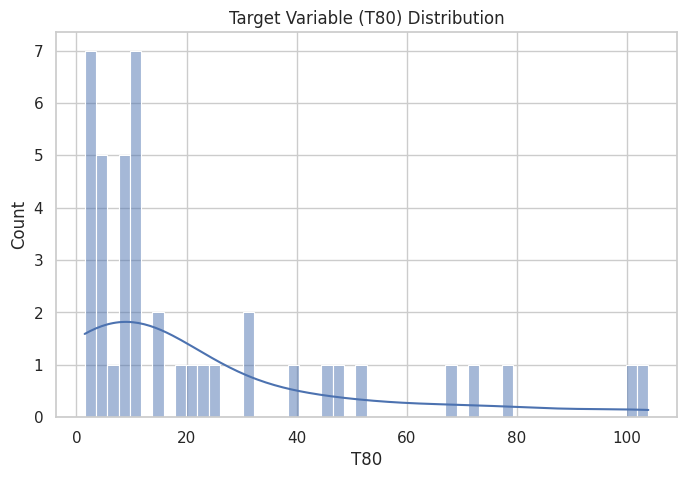

In [9]:
plt.figure(figsize=(8,5))
sns.histplot(df_tr['T80'], bins=50, kde=True)
plt.title('Target Variable (T80) Distribution')
plt.show()

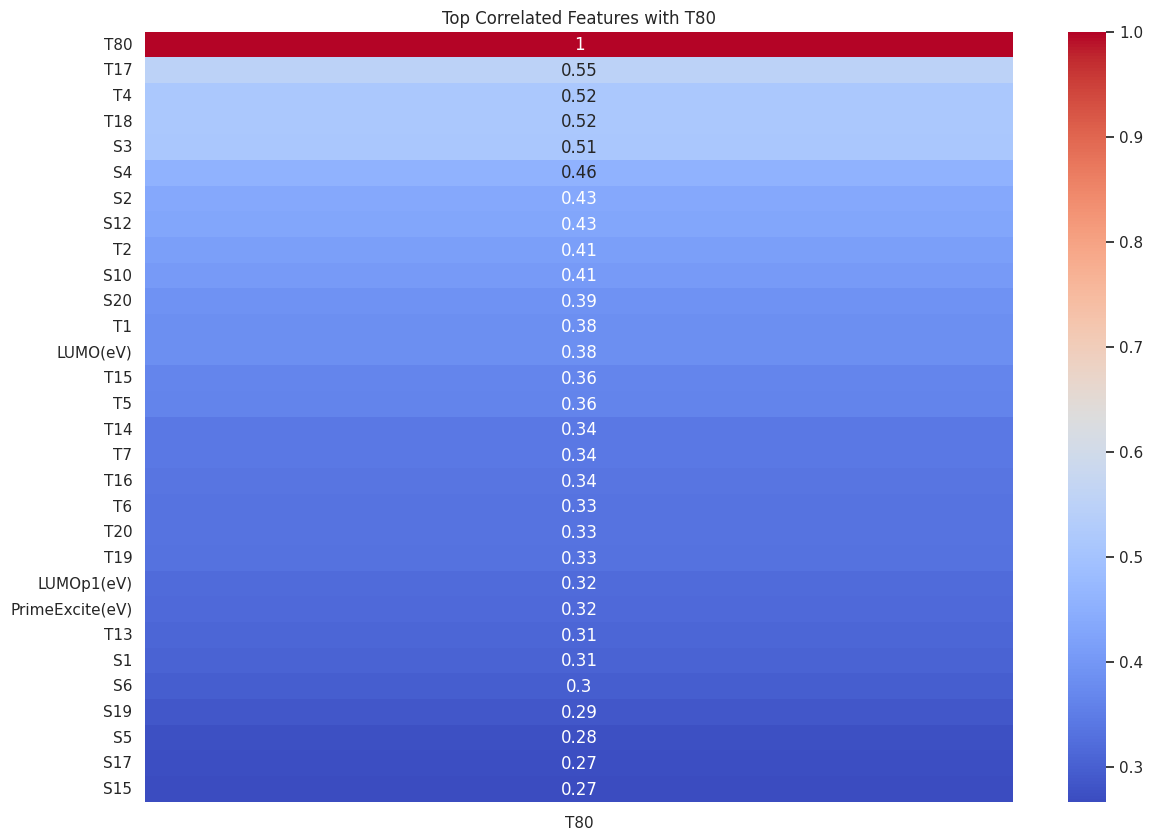

In [10]:
# Filter only numeric columns for correlation
numeric_df = df_tr.select_dtypes(include=[np.number])

# Now compute correlation safely
plt.figure(figsize=(14,10))
corr = numeric_df.corr()
sns.heatmap(corr[['T80']].sort_values(by='T80', ascending=False).head(30), annot=True, cmap='coolwarm')
plt.title('Top Correlated Features with T80')
plt.show()

In [11]:
# ====================================================
# 🧹 Preprocessing
# ====================================================
# Drop non-numeric or non-useful columns
df_tr = df_tr.drop(['Batch_ID', 'Smiles'], axis=1)

# Separate features and target
X = df_tr.drop('T80', axis=1)
y = df_tr['T80']
feature_columns = X.columns  # Save column names

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Process test data
df_ts = df_ts.drop(['Batch_ID', 'Smiles'], axis=1)
df_ts = df_ts[feature_columns]  # Use saved column names
X_test_scaled = scaler.transform(df_ts)

In [12]:
# Models # 🤖 Model Training:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42, n_jobs=-1)
lgb = LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42)

# Stacking
stacked_model = StackingRegressor(
    estimators=[('xgb', xgb), ('lgb', lgb)],
    final_estimator=rf,
    n_jobs=-1
)

# Train stacked model
stacked_model.fit(X_train, y_train)

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('lgb',
                               LGBMRegressor(learning_rate=0.05,
                                             n_estimators=200,
                                             random_state=42))],
                  final_estimator=RandomForestRegressor(n_estimators=200,
                                                        random_state=42),
                  n_jobs=-1)

In [13]:
val_preds = stacked_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
r2 = r2_score(y_val, val_preds)
print(f"\nValidation RMSE: {rmse:.4f}")
print(f"Validation R^2 Score: {r2:.4f}")


Validation RMSE: 22.3121
Validation R^2 Score: -0.1803


In [14]:
# Predict and save submission
submission_preds = stacked_model.predict(X_test_scaled)
submission_file["T80"] = submission_preds
submission_file.to_csv("submission.csv", index=False)